# Complaint Categorization Baseline Model

## Data Source:
1.	https://www.kaggle.com/datasets/sebastienverpile/consumercomplaintsdata
2.	https://catalog.data.gov/dataset/consumer-complaint-database

The data consists of 18 columns, of which we will focus on 2:
1.	The text of a consumer complaint
2.	The product against which this complain is registered.

There are 18 kinds of products of a financial nature, such as debt collection or consumer loans, in the full dataset.
Close to one million rows of data are available (903983). We will curtail this to 1000 rows for the sake of faster compute.
The length of the text per complaint is variable, which is a common situation in NLP tasks.\
TASK: We will create a multi-class classification model and try to predict which product a given complaint refers to
>
## GENERAL APPROACH
1.	Convert the complaint text into its numerical representation using TF-IDF scores.
2.	Convert the product classes into numbers using label encoding.
3.	Create a conventional machine learning model to complete the task. Since this is an introduction to NLP and we have chosen to work with truncated data, deep learning methods are not discussed.


In [ ]:
import os
import io
#os.environ['CONDA_DEFAULT_ENV']
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from google.colab import files
uploaded=files.upload()
df_full = df = pd.read_csv(io.BytesIO(uploaded['Consumer_Complaints.csv']))
df_full.head()



Saving Consumer_Complaints.csv to Consumer_Complaints (1).csv


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,3/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,3/17/2014,Closed with explanation,Yes,No,759217
1,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/5/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100
3,6/8/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,6/10/2014,Closed with explanation,Yes,Yes,885638
4,9/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,9/13/2014,Closed with explanation,Yes,Yes,1027760


In [ ]:
# How many unique financial products (the second column) are we talking about here
df_full['Product'].nunique()

18

In [ ]:
# The shape of the full, unmodified data
print('Shape of data',df_full.shape)

Shape of data (903983, 18)


In [ ]:
# The idea is to demonstrate a workflow, so we will work with a smaller portion of the data

# First, we retain only the columns relevant to our present purpose

df=df_full[['Consumer complaint narrative','Product']]
print('Shape of data',df.shape)

Shape of data (903983, 2)


In [ ]:
# Next, we get rid of nulls
print('Before dropping the nulls')
display('Null count', df.isna().sum())
print('Total rows of data', len(df))
df.dropna(inplace=True)
print('='*80)
print('After dropping the nulls')
display('Null count', df.isna().sum())
print('Total rows of data', len(df))

Before dropping the nulls


'Null count'

Consumer complaint narrative    704013
Product                              0
dtype: int64

Total rows of data 903983
After dropping the nulls


<ipython-input-15-1010b9478bc2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


'Null count'

Consumer complaint narrative    0
Product                         0
dtype: int64

Total rows of data 199970


In [ ]:
df=df.head(1000).reset_index(drop=True)
display(df.head())
display(df.tail())

,Consumer complaint narrative,Product
0,I have outdated information on my credit repor...,Credit reporting
1,I purchased a new car on XXXX XXXX. The car de...,Consumer Loan
2,An account on my credit report has a mistaken ...,Credit reporting
3,This company refuses to provide me verificatio...,Debt collection
4,This complaint is in regards to Square Two Fin...,Debt collection


,Consumer complaint narrative,Product
995,On or around XX/XX/XXXX I was first contacted ...,Debt collection
996,I am one of the many borrowers that has my loa...,Student loan
997,I refinanced i year ago and the lender failed ...,Mortgage
998,"XXXX account # XXXX I have insurance, I paid m...",Credit reporting
999,I have XXXX hard inquiries from Safe Rent ( XX...,Mortgage


In [ ]:
print('Shape of data',df.shape)

Shape of data (1000, 2)


In [ ]:
df.tail()

,Consumer complaint narrative,Product
995,On or around XX/XX/XXXX I was first contacted ...,Debt collection
996,I am one of the many borrowers that has my loa...,Student loan
997,I refinanced i year ago and the lender failed ...,Mortgage
998,"XXXX account # XXXX I have insurance, I paid m...",Credit reporting
999,I have XXXX hard inquiries from Safe Rent ( XX...,Mortgage


In [ ]:
# Kinds of products on which complaints are generated
df['Product'].nunique()

11

In [ ]:
#typical complaint
df['Consumer complaint narrative'][0]

'I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements'

In [ ]:
#categories of product - the classes for which we will predict
list(df.Product.unique())

['Credit reporting',
 'Consumer Loan',
 'Debt collection',
 'Mortgage',
 'Credit card',
 'Other financial service',
 'Bank account or service',
 'Student loan',
 'Money transfers',
 'Payday loan',
 'Prepaid card']

In [ ]:
df['Product'].value_counts()

Debt collection            253
Mortgage                   194
Credit reporting           192
Credit card                124
Bank account or service     94
Consumer Loan               56
Student loan                56
Payday loan                 13
Money transfers              9
Prepaid card                 7
Other financial service      2
Name: Product, dtype: int64

In [ ]:
#Train-test split
#25% of the total data is used as validation data while the remaining as training.
X_train, X_test, y_train, y_test = train_test_split(
                                            df['Consumer complaint narrative'], df['Product'], 
                                            test_size=0.25, random_state=0, stratify=df['Product'])
print(f'Training utterances: {len(X_train)} of shape {X_train.shape}')
print(f'Validation utterances: {len(X_test)} of shape {X_test.shape}')

# NOTE: The features occupy a single column

Training utterances: 750 of shape (750,)
Validation utterances: 250 of shape (250,)


In [ ]:
display(y_train.value_counts())

Debt collection            190
Mortgage                   145
Credit reporting           144
Credit card                 93
Bank account or service     70
Consumer Loan               42
Student loan                42
Payday loan                 10
Money transfers              7
Prepaid card                 5
Other financial service      2
Name: Product, dtype: int64

In [ ]:
display(y_test.value_counts())

Debt collection            63
Mortgage                   49
Credit reporting           48
Credit card                31
Bank account or service    24
Consumer Loan              14
Student loan               14
Payday loan                 3
Money transfers             2
Prepaid card                2
Name: Product, dtype: int64

In [ ]:
#Calculating tf-idf scores
#Calculating tf-idf scores for each unique token in the dataset and creating frequency chart for each utterance in the dataset.
# instantiate the vectorizer object
vectorizer = TfidfVectorizer(stop_words= 'english')
# convert the documents into a matrix
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)
X_train_vec, X_test_vec

(<750x5985 sparse matrix of type '<class 'numpy.float64'>'
 	with 40191 stored elements in Compressed Sparse Row format>,
 <250x5985 sparse matrix of type '<class 'numpy.float64'>'
 	with 12470 stored elements in Compressed Sparse Row format>)

In [ ]:
#Feature Selection
#SelectKBest Select features according to the k highest scores.
from sklearn.feature_selection import SelectKBest, chi2

n_features=100

ch2 = SelectKBest(chi2, k=n_features)
X_train_sp = ch2.fit_transform(X_train_vec, y_train)
X_test_sp  = ch2.transform(X_test_vec)

X_train_sp, X_test_sp

(<750x100 sparse matrix of type '<class 'numpy.float64'>'
 	with 2446 stored elements in Compressed Sparse Row format>,
 <250x100 sparse matrix of type '<class 'numpy.float64'>'
 	with 817 stored elements in Compressed Sparse Row format>)

In [ ]:
# Converting the sparse matrix to a dense one to visualize it.

cols = list(range(n_features))

X_train_dense = pd.DataFrame(data=X_train_sp.toarray(), columns=cols)
X_test_dense  = pd.DataFrame(data=X_test_sp.toarray(), columns=cols)
print(X_train_dense.shape, X_test_dense.shape)
X_train_dense

(750, 100) (250, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084352,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Now we have train and test data as vectors
# Let us also convert the target data appropriately

 
encoder = LabelEncoder()
y_train_num  = encoder.fit_transform(y_train)
y_test_num   = encoder.transform(y_test)
y_train_num.min(), y_train_num.max(), y_test_num.min(), y_test_num.max() # sanity check

(0, 10, 0, 10)

In [ ]:
# What does the target look like, after encoding. Check out the first n datapoints
n=5
print('Text   Encoding')
print('-'*50)
for p,q in zip(y_train[:n].values,y_train_num):
    print(f'{q}      {p}')

Text   Encoding
--------------------------------------------------
0      Bank account or service
6      Mortgage
6      Mortgage
4      Debt collection
4      Debt collection


In [ ]:
# Now, if you are fussy and want to see exactly what kind of encoding has happened.
mapping = {l: i for i, l in enumerate(encoder.classes_)}
mapping

{'Bank account or service': 0,
 'Consumer Loan': 1,
 'Credit card': 2,
 'Credit reporting': 3,
 'Debt collection': 4,
 'Money transfers': 5,
 'Mortgage': 6,
 'Other financial service': 7,
 'Payday loan': 8,
 'Prepaid card': 9,
 'Student loan': 10}

In [ ]:
#Our data is ready for modelling
#We want to train a model such that looking at the complaint text, it should be able to determine which category of complaint it deals with.

rf_model  = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs = -1)
scores = cross_val_score(rf_model,
                         X_train_dense,
                         y_train_num,
                         cv=5,
                         n_jobs = -1,
                         scoring = 'accuracy')
scores.mean()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


0.6973333333333332

In [ ]:
rf_model.fit(X_train_dense, y_train_num)
preds=rf_model.predict(X_test_dense)
print('Predictions ready')

Predictions ready


In [ ]:
# What does a prediction look like - let's take the first one
preds[0]


2

In [ ]:
# Let's revert back to the categories we understand
preds=encoder.inverse_transform(preds)
preds[0]


'Credit card'

In [ ]:
#Let's look at the predictions we made
report = pd.DataFrame(columns=['Complaint','Actual Product','Prediction'])
report['Complaint']      = X_test
report['Actual Product'] = y_test 
report['Prediction']     = preds
report

,Complaint,Actual Product,Prediction
193,I have been with USAA for more than 10 years a...,Credit card,Credit card
720,paid off debt for XXXX sent me to collection f...,Debt collection,Debt collection
462,I made an online payment to Citi Bank on the C...,Credit card,Bank account or service
600,I would like help from the CFPB to have Suntru...,Mortgage,Mortgage
932,XX/XX/2017 XXXX XXXX XXXX XXXX XXXX XXXX XXXX ...,Debt collection,Debt collection
...,...,...,...
724,I opened a Citigold checking account with Citi...,Bank account or service,Mortgage
244,We lived in apartments in 2013. I was 7 months...,Debt collection,Debt collection
138,I am filing this complaint because Equifax has...,Credit reporting,Credit reporting
856,I used to live in Campus Habitat Apartments fo...,Debt collection,Debt collection


In [ ]:
## How accurate is this model?
report['Correct'] = (report['Actual Product'] == report['Prediction']).astype('int')
display(report)
print(f'Accuracy: {100*report.Correct.sum()/report.Correct.count()} %')

,Complaint,Actual Product,Prediction,Correct
193,I have been with USAA for more than 10 years a...,Credit card,Credit card,1
720,paid off debt for XXXX sent me to collection f...,Debt collection,Debt collection,1
462,I made an online payment to Citi Bank on the C...,Credit card,Bank account or service,0
600,I would like help from the CFPB to have Suntru...,Mortgage,Mortgage,1
932,XX/XX/2017 XXXX XXXX XXXX XXXX XXXX XXXX XXXX ...,Debt collection,Debt collection,1
...,...,...,...,...
724,I opened a Citigold checking account with Citi...,Bank account or service,Mortgage,0
244,We lived in apartments in 2013. I was 7 months...,Debt collection,Debt collection,1
138,I am filing this complaint because Equifax has...,Credit reporting,Credit reporting,1
856,I used to live in Campus Habitat Apartments fo...,Debt collection,Debt collection,1


Accuracy: 74.8 %


In [ ]:
# Another way to crunch numbers
r = pd.DataFrame()
r['Correctly Predicted'] = report.groupby('Actual Product').sum()['Correct']
r['Overall Predicted']   = report.groupby('Prediction').count()['Correct']
r['Actuals']             = report.groupby('Actual Product').count()['Correct']
r

<ipython-input-38-579953980ebf>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r['Correctly Predicted'] = report.groupby('Actual Product').sum()['Correct']


,Correctly Predicted,Overall Predicted,Actuals
Actual Product,,,
Bank account or service,14,19.0,24
Consumer Loan,5,12.0,14
Credit card,24,35.0,31
Credit reporting,39,48.0,48
Debt collection,53,72.0,63
Money transfers,0,NaN,2
Mortgage,42,54.0,49
Payday loan,0,NaN,3
Prepaid card,0,NaN,2


In [ ]:
# Or you could do it in a more mundane way
print(rf_model.score(X_test_dense, y_test_num))

0.748


In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,labels,size=10, rotate_labels=False):
    '''
    This function receives a confusion matrix object and plots it out using seaborn
    '''
    import seaborn as sns
    import matplotlib.pyplot as plt
    font_specs = {"size": 20, 'fontweight':'bold'}
    title_specs= {"size": 16, 'fontweight':'bold'}
    figsize = size
    fig, ax = plt.subplots(figsize = (figsize,figsize), facecolor = '#ebebeb', frameon = True, edgecolor = 'black')
    ax = sns.heatmap(cm,annot=True, cbar = False, cmap = 'Blues',linewidths=5,
                  linecolor='#ebebeb', annot_kws=font_specs, fmt='g')
    plt.xlabel('Predicted', fontdict = font_specs, labelpad=-(figsize*65))
    plt.ylabel('Actual', fontdict = font_specs, labelpad=15)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    if rotate_labels:
        ax.set_xticklabels(labels, rotation=90, ha='center')  
        ax.set_yticklabels(labels, rotation=0, ha='right')    
    
    ax.tick_params(labelbottom=False, labeltop=True, labelsize = 12, colors ='#151736' )
    plt.title('CONFUSION MATRIX',loc = 'right', pad = figsize*4 , fontdict = title_specs)
    plt.show()
print('custom function defined')   

custom function defined


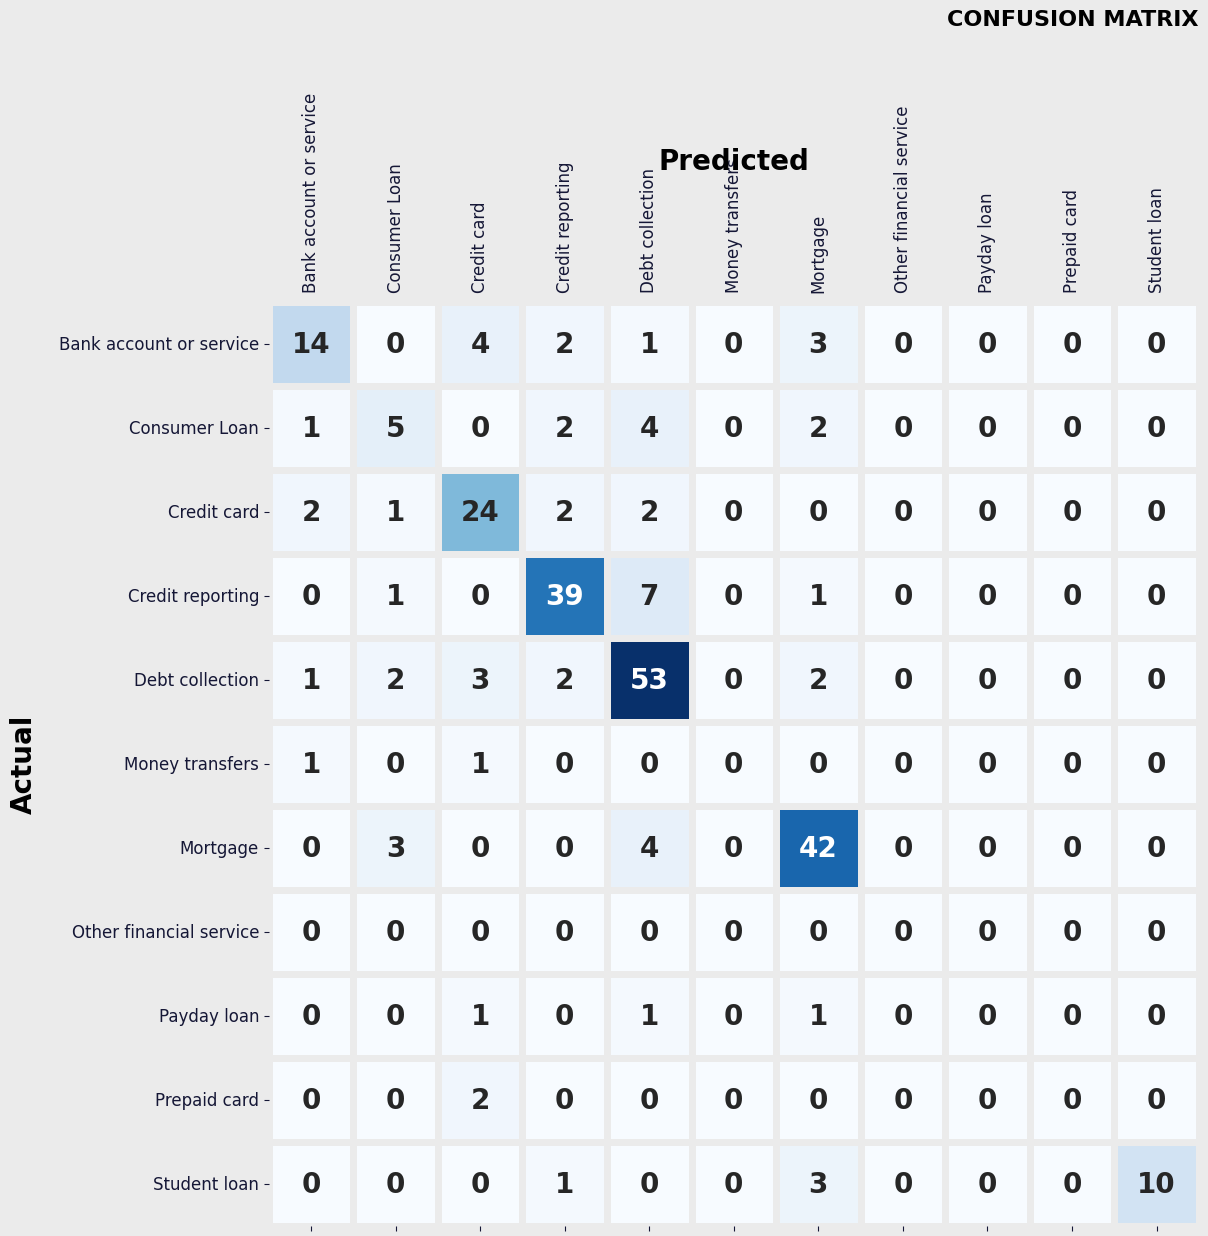

In [ ]:
cm = confusion_matrix(y_test, preds, labels=encoder.classes_)
plot_confusion_matrix(cm=cm,labels=encoder.classes_, size=12, rotate_labels=True)